In [1]:
from methods.config import *
import numpy as np; rnd=np.random.default_rng()
import matplotlib.pyplot as plt; import matplotlib as mpl
import scipy.stats

import pickle
import methods.util as util
import methods.shared as shared
import methods.sim_barcodes as sim

In [6]:
## Summary of high-frequency, high-fitness barcodes 
expt = 'E1'
fit_barcodes = {}
mouse_specific_high_frequency_barcodes = {}

mice_in_each_col = [(1,2,3,4,5), (6,7,8,9,10), (11,12,13)]
init_day, fin_day = 9, 15

for col, (m_set, colors, title) in enumerate( zip(mice_in_each_col, ['Blues', 'Oranges', 'Reds'], ['SD (P2)', 'SD (P1)', 'MD (P1)']) ):
    for single_mouse in m_set:
        large_indices = shared.find_large_barcodes(expt, [single_mouse], max_cutoff=1e-2, final_cutoff=1)
        mouse_specific_high_frequency_barcodes[single_mouse] = large_indices

In [10]:
## What is the minimum number of adaptive barcodes that could account for the 
## declining median fold-change of the typical barcode

for mice, median_fold_change in zip([[1,2,3,4,5], [6,7,8,9,10], [11,12,13]], 
                                    [0.7, 0.5, 0.3]): #rough median fold-change in each cage at day 9
    for m in mice:
        if m <= 5:
            plate = 'P2'
        else:
            plate = 'P1'

        try:
            a = mouse_specific_high_frequency_barcodes[m]
            bc = shared.barcode_pool_assignments[plate][1]
            f0 = shared.freq_array[ m ] + 1e-6
            f1 = shared.freq_array[ shared.vivo_row_ids[('E1', m, 9)] ]
            fc = f1[bc] / f0[bc]
            deff = shared.Deff_array[ shared.vivo_row_ids[('E1', m, 9)] ]
        except:
            continue

        sorting = np.argsort(f1[bc])[::-1] #sort from largest to smallest
        cum_freq0, cum_freq, n_bc = 0, 0, 0
        for f, finit, fold_change, idx in zip(f1[bc][sorting], f0[bc][sorting], fc[sorting], sorting):
            if idx in a or fold_change > 0: #include in adaptive lineages if grew in interval
                cum_freq += f
                cum_freq0 += finit
                n_bc += 1
            if (1-cum_freq)/(1-cum_freq0) < median_fold_change:
                break
        print(f"Mouse {m}, MFC at day 9 = {median_fold_change}, accounted for by >{n_bc} adaptive lienages")

Mouse 1, median fold-change at day 9 = 0.7, accounted for by >717 adaptive lienages
Mouse 2, median fold-change at day 9 = 0.7, accounted for by >254 adaptive lienages
Mouse 3, median fold-change at day 9 = 0.7, accounted for by >285 adaptive lienages
Mouse 4, median fold-change at day 9 = 0.7, accounted for by >363 adaptive lienages
Mouse 5, median fold-change at day 9 = 0.7, accounted for by >212 adaptive lienages
Mouse 6, median fold-change at day 9 = 0.5, accounted for by >774 adaptive lienages
Mouse 7, median fold-change at day 9 = 0.5, accounted for by >706 adaptive lienages
Mouse 8, median fold-change at day 9 = 0.5, accounted for by >956 adaptive lienages
Mouse 9, median fold-change at day 9 = 0.5, accounted for by >1002 adaptive lienages
Mouse 10, median fold-change at day 9 = 0.5, accounted for by >1353 adaptive lienages
Mouse 11, median fold-change at day 9 = 0.3, accounted for by >811 adaptive lienages
Mouse 12, median fold-change at day 9 = 0.3, accounted for by >644 adapt

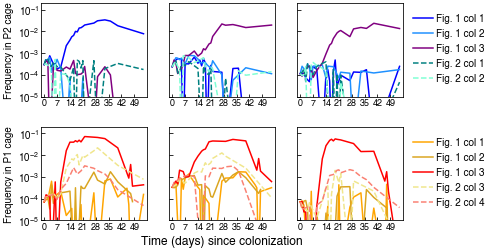

In [11]:
###  plot a few "locally adapted" examples
mouse_colors = {1:'blue', 2:'dodgerblue', 3:'purple', 4:'teal', 5:'aquamarine',  8:'orange', 9:'goldenrod', 10:'red', 6:'khaki', 7:'salmon'}
relabel_mice = {1:'Fig. 1 col 1', 2:'Fig. 1 col 2', 3:'Fig. 1 col 3', 4:'Fig. 2 col 1', 5:'Fig. 2 col 2', 
                8:'Fig. 1 col 1', 9:'Fig. 1 col 2', 10:'Fig. 1 col 3', 6:'Fig. 2 col 3', 7:'Fig. 2 col 4'}
P2_examples = ['AACCTAATTGTACCGGTCCG', 'GGTACGAACGGTAACCCAGA', 'TAAGTACTTGGCGATTTTCT']
P1_examples = ['ACAAACATATCAGTGCTCTC', 'TGCGCACAGTGGTCACTCTC', 'TATGTTAGATAGGGATAAAC']

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
fig = plt.figure(figsize=(6.5,4))
gs = plt.GridSpec(3, 3, height_ratios=(1, 0.05, 1))

for row, (mice, examples, cage) in enumerate(zip([[1,2,3,4,5], [8,9,10,6,7]], [P2_examples, P1_examples], ['P2 cage', 'P1 cage'])):
    for col, example_bc in enumerate(examples):
        ax = fig.add_subplot(gs[2*row, col])
        bc_index = np.where(shared.barcodes == example_bc)[0][0]

        for mouse in mice:
            ls = 'solid'
            if mouse in [4,5,6,7]:
                ls = '--'
            days, rows, cec_id = shared.mouse_meta['E1'][mouse]
            ax.plot(days, shared.freq_array[rows, bc_index] + 1e-7, label=f'{relabel_mice[mouse]}', color=mouse_colors[mouse], ls=ls, lw=1.5)
        ax.set_yscale('log')
        ax.set_ylim(1e-5, 2e-1)
        ax.set_xlim(-2, 56)
        ax.set_xticks([0, 7, 14, 21, 28, 35, 42, 49])
        ax.set_xticklabels([0, 7, 14, 21, 28, 35, 42, 49], fontsize=9)
        ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
        if col > 0:
            ax.set_yticklabels([])
        if col == 0:
            ax.set_ylabel(f'Frequency in {cage}', fontsize=10)
        if row == 1 and col == 1:
            ax.set_xlabel(f'Time (days) since colonization', fontsize=12)

        if col == 2:
            ax.legend(loc=(1.05, 0.1), ncol=1, fontsize=10, frameon=False, bbox_transform=ax.transAxes, handletextpad=0.3, columnspacing=1.0)

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/sfig_monocolonization_locally_adapted_example.pdf')

[(1, 282, 2.911123402521033e-05), (2, 255, 4.092155338216639e-05), (3, 210, 3.9019822069611365e-05), (4, 342, 2.299590672860231e-05), (5, 205, 3.898027598035394e-05), (6, 170, 9.39584703561026e-05), (7, 141, 5.170898185014737e-05), (8, 103, 0.00011029006286533584), (9, 149, 2.7607531334548064e-05), (10, 45, 0.00039824771007566706), (11, 30, 0.001199040767386091), (12, 75, 0.0002295684113865932), (13, 41, 0.0005473453749315818)]


/Users/daniel/Documents/GoodLab/btheta_barcoded_evolution/notebooks/methods/shared.py:451: RuntimeWarning: invalid value encountered in reciprocal
  neutral_sim_freqs = sim.neutral_sim(day0_freqs, Ntau, mouse_days, mouse_floors**-1.)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_21171/1490622004.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


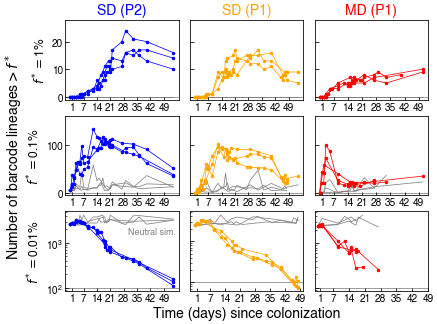

In [12]:
## barcodes at >x% frequency
fig = plt.figure(figsize=(6.5, 5))
gs = plt.GridSpec(3,3, figure=fig, wspace=0.1)
outer_ax = fig.add_subplot(gs[:, :])
util.turn_off_ax(outer_ax)
outer_ax.set_ylabel(r'Number of barcode lineages > $f^*$', fontsize=14, labelpad=40)
outer_ax.set_xlabel(r'Time (days) since colonization', fontsize=14, labelpad=15)
                 
expt = 'E1'
print( [ (mouse, (shared.freq_array[shared.mouse_meta[expt][mouse][1][-1]] > shared.Deff_array[shared.mouse_meta[expt][mouse][1][-1]]**-1.).sum(),shared.Deff_array[shared.mouse_meta[expt][mouse][1][-1]]**-1.) for mouse in range(1, 14)]  )
Ntau = 10**6
for row, (cutoff, cutoff_label) in enumerate(zip([1e-2, 1e-3, 1e-4], ['1%', '0.1%', '0.01%'])):
    for col, (mice, label, color) in enumerate(zip([[1,2,3], [8,9,10], [11, 12, 13]],
                                                   ['SD (P2)', 'SD (P1)', 'MD (P1)'],
                                                   ['blue', 'orange', 'red'])):
        ax = fig.add_subplot(gs[row, col])

        min_depth = np.min([10**4, 3*cutoff**-1.])
        for mouse in mice:
            days, n_barcodes_above_cutoff = shared.estimate_num_barcodes_above_cutoff('E1', mouse, cutoff, min_depth = min_depth)
            ax.plot(days, n_barcodes_above_cutoff, marker='.', color=color, markersize=5)
            sim_days, sim_n_barcodes_above_cutoff = shared.estimate_num_barcodes_above_cutoff_simulated('E1', mouse, cutoff, Ntau=Ntau, min_depth=min_depth)
            ax.plot(sim_days, sim_n_barcodes_above_cutoff, color='grey', zorder=0)

        if row == 0: 
            ax.set_title(label, color=color, fontsize=14)
        if col == 0:
            ax.set_ylabel(r'$f^*=$' + f'{cutoff_label}', fontsize=12)

        ax.set_xticks([1, 7, 14, 21, 28, 35, 42, 49])
        ax.set_xticklabels([1, 7, 14, 21, 28, 35, 42, 49], fontsize=10)

        if row == 2:
            # ax.set_ylim(1, 3500)
            # ax.set_yticks([100]+list(ax.get_yticks()))
            # ax.set_yticks([1, 100, 1000, 2000, 3000])
            ax.axhline(100, color='grey', zorder=0)
            ax.set_yscale('log')
        if row == 1:
            ax.set_ylim(-5, 160)
            ax.axhline(0, color='grey', zorder=0)
        if row == 0:
            ax.set_ylim(-1, 28)
            ax.axhline(0, color='grey', zorder=0)
        if col != 0:
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

        if row == 2 and col == 0:
            ax.text(0.98, 0.8, 'Neutral sim.', transform=ax.transAxes, color='grey', fontsize=9, ha='right', va='top')

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/sfig_E1_mono_num_barcodes_above_cutoff.pdf')